# Evaluation of Surrogate Models

Currently we use `RandomForestRegressor(n_estimators=100)` to train a surrogate model mapping hyperparameters to performance.
Before training the performance is normalized s.t. the worst recorded performances on the task is 0, and the best recorded performance is 1.
For each task, we train a separate surrogate model.

A `Problem` object is created, which is a wrapper for a configuration that specifies which hyperparameters to model, and which experiment data or surrogate models to load.

In [21]:
import sys
sys.path.append("./src/")
from problem import Problem

problem = Problem("mlr_svm")

We can now expect the underlying experiment data for the "mlr svm" problem:

In [25]:
problem.data.sample(5)

,task_id,dataset,learner,target,perf.logloss,traintime,predicttime,kernel,cost,gamma,tolerance,shrinking,num.impute.selected.cpo,fitted,degree
355946,146800.0,MiceProtein,classif.svm,-0.450000,1.462339,18.657,0.917,radial,0.044552,0.000256,0.004221,TRUE,impute.hist,FALSE,NaN
443489,190412.0,arcene,classif.svm.radial,-0.310000,0.601490,201.231,55.572,radial,12.880400,0.000319,0.008296,TRUE,impute.hist,FALSE,NaN
116858,9956.0,one.hundred.plants.texture,classif.svm,-0.988117,4.566155,42.077,1.830,radial,0.248358,58.552500,0.000281,TRUE,impute.mean,FALSE,NaN
163447,9950.0,micro.mass,classif.svm.radial,-0.894918,2.914914,70.480,3.429,radial,164.407000,0.652217,0.003173,TRUE,impute.median,FALSE,NaN
319536,125921.0,LED.display.domain.7digit,classif.svm,-0.314000,1.165760,2.187,0.316,radial,28.437700,2602.260000,0.003942,FALSE,impute.mean,FALSE,NaN


We can also access the metadata for each task (though we don't need it here):

In [7]:
problem.metadata.sample(5)

,m,n,p,rc,mcp,mkd,xvar
task_id,,,,,,,
14,10,2000,76,0.000000,0.100000,0.006712,1.000000
3913,2,522,21,0.000000,0.795019,0.116184,1.000000
31,2,1000,61,0.885246,0.700000,0.008274,0.282451
9970,2,1212,100,0.000000,0.500000,0.651083,1.000000
3,2,3196,73,1.000000,0.522215,0.008077,0.249953


And access the surrogate model by task:

In [9]:
problem.surrogates[3893]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

We will evaluate each surrogate model by its rmse, Spearman's $\rho$ and Kendall's $\tau$.
We use 10-fold cross-validation to obtain normalized score predictions for a surrogate model.

In [26]:
from scipy.stats import kendalltau, spearmanr, rankdata
from sklearn.metrics import mean_squared_error
import math

In [27]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor

cache = {}

def performance_for_task(problem, task: int, on_training_data=False):
    """ returns surrogate model predicted normalized scores, and normalized observed scores. """
    if not on_training_data and (problem, task) in cache:
        return cache[(problem, task)]
    
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    y = task_experiments.target
    normalized_scores = (y - min(y)) / (max(y) - min(y))
    
    if on_training_data:
        surrogate_scores = problem.surrogates[task].predict(task_configurations)
    else:
        surrogate = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        surrogate_scores = cross_val_predict(surrogate, task_configurations, normalized_scores, cv=10)
        cache[(problem, task)] = (surrogate_scores, normalized_scores)
    return surrogate_scores, normalized_scores

In [28]:
def calculate_rank_metrics(y_true, y_hat):
    """ Calculate Spearman's rho and Kendall's tau based on true and predicted model performance.
    
    Assumes that same index in y_true and y_hat represent the same sample.
    
    returns:
        - Spearman's rho
        - two-sided pvalue for rho
        - Kendall's tau
        - two-sided pvalue for tau
    """
    # Calculate orders
    true_order = rankdata(y_true, method='average')
    pred_order = rankdata(y_hat, method='average')
    
    rho, p_rho = spearmanr(true_order, pred_order)
    tau, p_tau = kendalltau(true_order, pred_order)
    return rho, p_rho, tau, p_tau  

In [29]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

def distplot(surrogate, actual, ax, bin_zero=False):
    """ Plots the two distributions """
    _ = sns.distplot(surrogate, rug=True, kde=False, label='surrogate', ax=ax)
    _ = sns.distplot(actual, rug=True, kde=False, label='actual', ax=ax)
    _ = ax.set(xlabel='normalized score', ylabel='configurations', title=f'Distribution of Performance')
    # matplotlib inline will display the plot automagically
    
def scatter(df, x_col, y_col, c_col, title, ax, quantile=0.95):
    """ Scatterplot of (x_col, y_col) points, where the specified quantile is colored differently. """
    cut_off = df[c_col].quantile(quantile)
    df = df.assign(top_quantile=lambda r: r[c_col] > cut_off)
    ax = sns.scatterplot(x=x_col, y=y_col, hue="top_quantile", data=df, ax=ax)
    _ = ax.set(
        xscale="log", yscale="log", 
        xlim=(2**-32, 2**32), ylim=(2**-32, 2**32),
        title=title
    )

In [30]:
def score_surrogate(actual, predicted):
    """ Calculate some evaluation metrics for the surrogate model predictions. """
    rho, prho, tau, ptau = calculate_rank_metrics(actual, predicted)
    rmse = math.sqrt(mean_squared_error(actual, predicted))    
    return {
        "rho": rho,
        "prho": prho,
        "tau": tau,
        "ptau": ptau,
        "rmse": rmse,
        "quantile05": (actual - predicted).quantile(0.05),
        "quantile95": (actual - predicted).quantile(0.95)
    }

In [31]:
def incremental_rank_scores(actual, predicted, steps=20):
    rows = []
    for i in range(steps):
        ratio = i/steps
        cutoff = actual.quantile(ratio)
        
        actual_s = actual[actual > cutoff]
        predicted_s = predicted[actual > cutoff]
        rho, _, tau, _ = calculate_rank_metrics(actual_s, predicted_s)
        rows.append({'ratio': 1 - ratio, 'rho': rho, 'tau': tau})
    return rows

def rank_plot(actual, predicted, ax, steps=20):
    rows = incremental_rank_scores(actual, predicted, steps)
    df = pd.DataFrame(rows)
    sns.lineplot(x="ratio", y="rho", data=df, ax=ax, label="rho")
    sns.lineplot(x="ratio", y="tau", data=df, ax=ax, label="tau")
    ax.set(title='rho/tau on top x% of data')
    ax.set(xlabel="% of best configurations included", ylabel="correlation")
        

In [32]:
def plot_task_summary(problem, task):
    predicted, actual = performance_for_task(problem, task)
    
    unfiltered = score_surrogate(actual, predicted)
    scores = pd.DataFrame.from_dict(unfiltered, orient="index", columns=["unfiltered"])
    
    actual_filtered, predicted_filtered = actual[actual > 0], predicted[actual > 0]
    filtered = score_surrogate(actual_filtered, predicted_filtered)
    scores = scores.assign(filtered=filtered.values())
    
    top_10_percent = actual > actual.quantile(0.9)
    actual_10prct, predicted_10prct = actual[top_10_percent], predicted[top_10_percent]
    ten_percent = score_surrogate(actual_10prct, predicted_10prct)
    scores = scores.assign(ten_percent=ten_percent.values())
    
    print(f"Summary for Task {task}")
    print("The following dataframe shows rank metrics for the following subsets of configurations:")
    print(f" - unfiltered: calculated across all configurations ({len(actual)} points)")
    print(f" - filtered: calculated only on those configurations which scored higher than 0 normalized score ({sum(actual > 0)} points)")
    print(f" - filtered: calculated only on the top 10% of configurations ({sum(top_10_percent)} points)")
    with pd.option_context("display.float_format", "{:.4f}".format):
        display(scores.transpose())
        
    task_experiments = problem.data[problem.data.task_id == task]
    task_configurations = task_experiments[problem.hyperparameters]
    df = task_configurations.assign(actual=actual)
    df = df.assign(surrogate=predicted)
    df = df.assign(diff=abs(actual-surrogate))
        
    f, axes = plt.subplots(2, 2, figsize=(16, 7))
    # 4x4 plot. 
    # - score distributions
    # - score scatter: best 10% solutions, 10% greatest errors.
    # - same two plots with 0-score solutions left out.
    distplot(predicted, actual, axes[0, 0])
    df_filtered = df[df.actual > 0]
    # scatter(df_filtered, "gamma", "cost", "diff", "Biggest Mistakes Filtered (95%)", axes[1, 0])
    rank_plot(actual, predicted, axes[1, 0])
    scatter(df, "gamma", "cost", "actual", "Best Configurations (95%)", axes[0, 1])
    scatter(df, "gamma", "cost", "diff", "Biggest Mistakes (95%)", axes[1, 1])
    plt.tight_layout()

Summary for Task 3893
The following dataframe shows rank metrics for the following subsets of configurations:
 - unfiltered: calculated across all configurations (592 points)
 - filtered: calculated only on those configurations which scored higher than 0 normalized score (330 points)
 - filtered: calculated only on the top 10% of configurations (60 points)


,rho,prho,tau,ptau,rmse,quantile05,quantile95
unfiltered,0.9499,0.0000,0.8661,0.0000,0.0381,-0.0240,0.0260
filtered,0.9734,0.0000,0.8931,0.0000,0.0364,-0.0383,0.0379
ten_percent,0.6975,0.0000,0.5873,0.0000,0.0203,-0.0043,0.0630


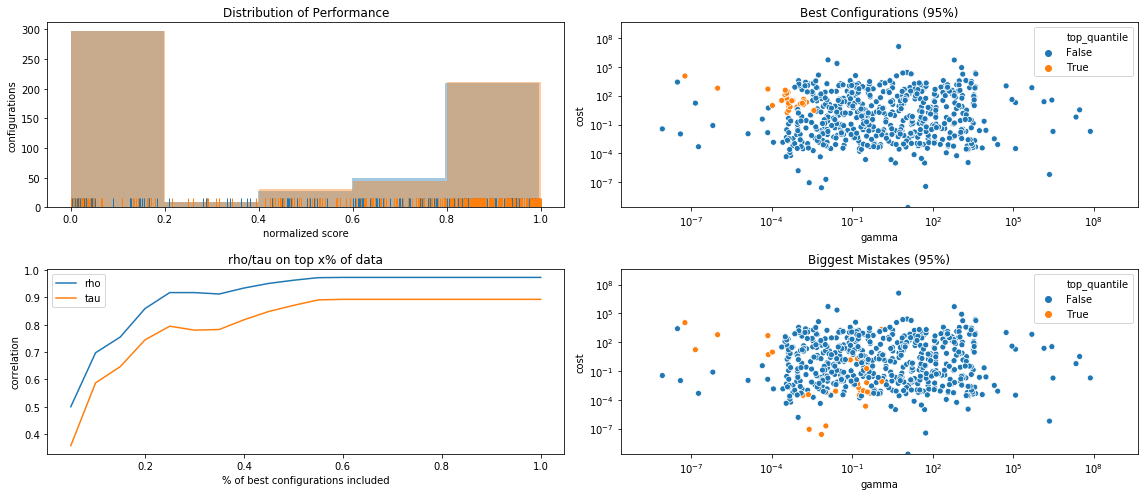

In [447]:
plot_task_summary(problem, task=3893)

In [33]:
data = df.pivot(index='gamma', columns='cost', values='d_score')
ax = sns.heatmap(data)
#ax.set(xlim=(9.29e-11, 3819), ylim=(8.28e-9, 54085))

NameError: name 'df' is not defined

-----

problem.data

In [390]:
rows = []
for i, task in enumerate(problem.data.task_id.unique()):
    print(f"{i:3d} / {len(problem.data.task_id.unique())}: {task}")
    predicted, actual = performance_for_task(problem, task)
    rows.append(score_surrogate(actual, predicted))

df = pd.DataFrame(rows)
df = df.assign(task=problem.data.task_id.unique())
df.head()

  0 / 106: 3893.0
  1 / 106: 3902.0
  2 / 106: 3903.0
  3 / 106: 3904.0
  4 / 106: 3907.0
  5 / 106: 3913.0
  6 / 106: 3917.0
  7 / 106: 3918.0
  8 / 106: 11.0
  9 / 106: 3945.0
 10 / 106: 12.0
 11 / 106: 14971.0
 12 / 106: 14.0
 13 / 106: 10090.0
 14 / 106: 14965.0
 15 / 106: 10093.0
 16 / 106: 10101.0
 17 / 106: 9981.0
 18 / 106: 9985.0
 19 / 106: 9986.0
 20 / 106: 14970.0
 21 / 106: 9970.0
 22 / 106: 9971.0
 23 / 106: 9976.0
 24 / 106: 9977.0
 25 / 106: 9978.0
 26 / 106: 9952.0
 27 / 106: 9956.0
 28 / 106: 9957.0
 29 / 106: 9960.0
 30 / 106: 15.0
 31 / 106: 9964.0
 32 / 106: 219.0
 33 / 106: 9946.0
 34 / 106: 9950.0
 35 / 106: 7592.0
 36 / 106: 16.0
 37 / 106: 18.0
 38 / 106: 2073.0
 39 / 106: 2074.0
 40 / 106: 2079.0
 41 / 106: 22.0
 42 / 106: 23.0
 43 / 106: 125920.0
 44 / 106: 24.0
 45 / 106: 28.0
 46 / 106: 29.0
 47 / 106: 3.0
 48 / 106: 3481.0
 49 / 106: 3022.0
 50 / 106: 31.0
 51 / 106: 3485.0
 52 / 106: 32.0
 53 / 106: 3493.0
 54 / 106: 37.0
 55 / 106: 3510.0
 56 / 106: 3512.

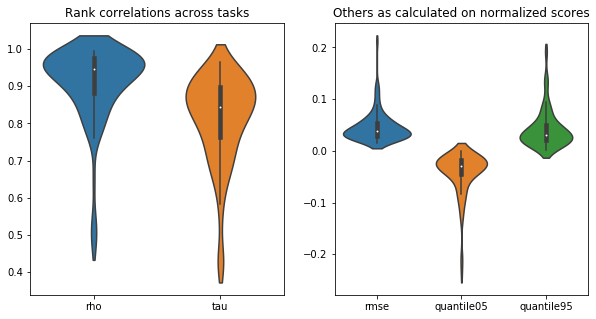

In [417]:
f, axes = plt.subplots(1, 2, figsize=(10, 5))
rank_metrics = df[['rho', 'tau']]
ax = sns.violinplot(data=rank_metrics, cut=1.0, ax=axes[0])
_ = ax.set(title='Rank correlations across tasks')

other_metrics = df[['rmse', 'quantile05', 'quantile95']]
ax = sns.violinplot(data=other_metrics, cut=1.0, ax=axes[1])
_ = ax.set(title='Others as calculated on normalized scores')

In [34]:
rows = []
for task in problem.data.task_id.unique():
    predicted, actual = performance_for_task(problem, task)
    inc_scores = incremental_rank_scores(actual, predicted)
    for score in inc_scores:
        score['task'] = task
    rows += inc_scores
    
df = pd.DataFrame(rows)

/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/home/flo/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/flo/.local/lib/python3.6/site-packa

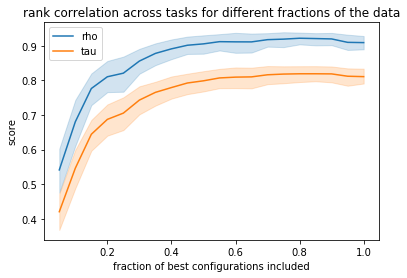

In [35]:
ax = sns.lineplot(x="ratio", y="rho", data=df, label="rho")
ax = sns.lineplot(x="ratio", y="tau", data=df, label="tau")
_ = ax.set(
    title="rank correlation across tasks for different fractions of the data",
    ylabel="score",
    xlabel="fraction of best configurations included"
)

----

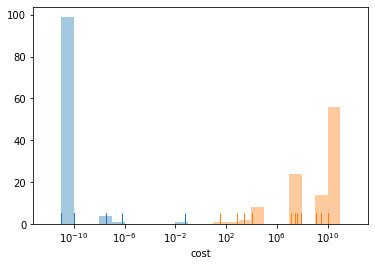

In [527]:
bins = list(np.logspace(-12, 12, 25))
ax = sns.distplot(problem.data.groupby(by='task_id').min().cost, kde=False, rug=True, bins=bins, label='min')
ax = sns.distplot(problem.data.groupby(by='task_id').max().cost, kde=False, rug=True, bins=bins, label='max')
ax.set_xscale("log")

In [37]:
problem.data.groupby(by='task_id').min().cost

task_id
3.0         1.008280e-11
6.0         9.296000e-11
11.0        1.008280e-11
12.0        1.008280e-11
14.0        1.008280e-11
15.0        1.008280e-11
16.0        1.008280e-11
18.0        1.008280e-11
22.0        1.008280e-11
23.0        1.008280e-11
24.0        9.296000e-11
28.0        9.296000e-11
29.0        1.008280e-11
31.0        1.008280e-11
32.0        9.296000e-11
37.0        1.008280e-11
41.0        1.008280e-11
43.0        9.296000e-11
45.0        9.296000e-11
49.0        1.008280e-11
53.0        1.008280e-11
58.0        9.296000e-11
219.0       3.546570e-08
2073.0      1.008280e-11
2074.0      9.296000e-11
2079.0      1.008280e-11
3021.0      1.008280e-11
3022.0      1.008280e-11
3481.0      9.296000e-11
3485.0      1.008280e-11
                ...     
145681.0    1.008280e-11
146195.0    3.546570e-08
146212.0    9.296000e-11
146607.0    9.296000e-11
146800.0    1.008280e-11
146817.0    1.008280e-11
146818.0    1.008280e-11
146819.0    1.008280e-11
146820.0    1.008

In [128]:
min(problem.data.groupby(by='task_id').max().cost)

31.8767

In [196]:
import itertools
import numpy as np

min_c = problem.data.groupby(by='task_id')

costs = np.geomspace(problem.data.cost.min(), problem.data.cost.max(), 200)
gammas = np.geomspace(problem.data.gamma.min(), problem.data.gamma.max(), 200)
configurations = list(itertools.product(costs, gammas))

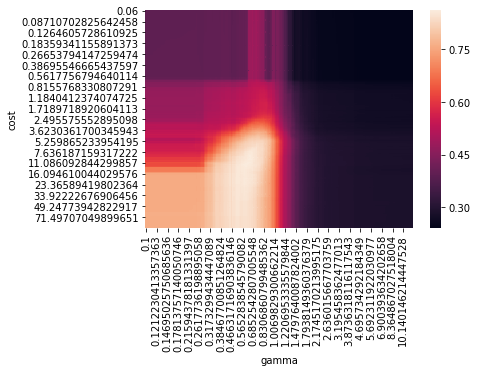

In [197]:
for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

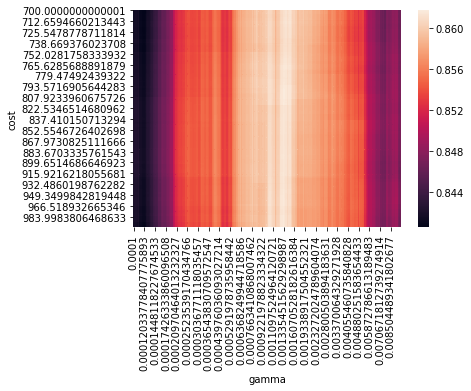

In [131]:
# Zoomed in:
costs = np.geomspace(7e2, 1e3, 200)
gammas = np.geomspace(1e-4, 1e-2, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])

for task, surrogate in problem.surrogates.items():
    scores = surrogate.predict(configurations)
    surrogate_scores[task] = scores
    
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

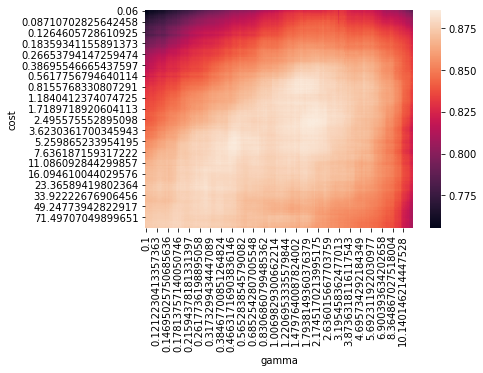

In [193]:
# Warp with metafeatures m, mkd
costs =  np.geomspace(6e-2, 100, 200)
gammas = np.geomspace(1e-1, 12, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])


for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs * problem.metadata.loc[task, "m"], gammas * problem.metadata.loc[task,"mkd"]))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

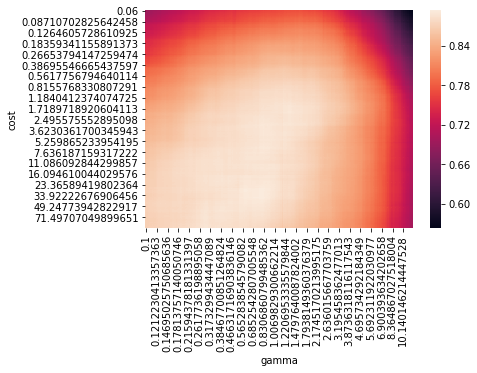

In [195]:
# Warp with metafeatures 1 / (p*xvar)
costs =  np.geomspace(6e-2, 100, 200)
gammas = np.geomspace(1e-1, 12, 200)
configurations = list(itertools.product(costs, gammas))
surrogate_scores = pd.DataFrame(list(configurations), columns=['cost','gamma'])


for task, surrogate in problem.surrogates.items():
    if (task in problem.metadata.index):
        cfgs = list(itertools.product(costs, gammas * (1 / problem.metadata.loc[task,"p"] / problem.metadata.loc[task,"xvar"])))
        scores = surrogate.predict(cfgs)
        surrogate_scores[task] = scores
        
surrogate_scores["mean"] = surrogate_scores.iloc[:, 2:].mean(axis=1)

surrogate_pivot = surrogate_scores.pivot("cost", "gamma", "mean")
sns.heatmap(surrogate_pivot)

In [170]:
# List of settings:
d0 = surrogate_scores.loc[surrogate_scores["mean"] == max(surrogate_scores["mean"])]

,3902,3903,3904,3913,3917,3918,11,12,14,14965,...,43,14969,3549,45,3560,3561,49,53,6,58
27484,0.958352,0.960557,0.751433,0.640503,0.860728,0.320783,0.936777,0.998285,0.992734,0.915727,...,0.993204,0.889015,0.998119,0.977924,0.579305,0.605355,0.952173,0.941012,0.979379,0.98079


In [183]:
best_idx = 0
best = 0
for idx, row in surrogate_scores.iterrows():
    newmax = np.mean(np.maximum(row.iloc[2:-1].values, d0.iloc[:,2:-1].values))
    if (newmax > best):
        print(f"Newmax found: {newmax}")
        best = newmax
        best_idx = idx

surrogate_scores.iloc[best_idx,:]

Newmax found: 0.8930530511062775
Newmax found: 0.8939457507765681
Newmax found: 0.8940728629178913
Newmax found: 0.8946011389790289
Newmax found: 0.8947244019785487
Newmax found: 0.895290514411588
Newmax found: 0.8963397036486833
Newmax found: 0.8965284823421962
Newmax found: 0.8970647003369056
Newmax found: 0.8973637164802817
Newmax found: 0.8982009084221168
Newmax found: 0.898462523549207
Newmax found: 0.8985622089008126
Newmax found: 0.8987589826125882
Newmax found: 0.8990896977635131
Newmax found: 0.8994178266746307
Newmax found: 0.899493616751929
Newmax found: 0.9006004294015917
Newmax found: 0.9006097890424842
Newmax found: 0.9007903114266517
Newmax found: 0.9015274450580404
Newmax found: 0.9015802652972859
Newmax found: 0.9016596440877666
Newmax found: 0.9017750169296418
Newmax found: 0.9031059848593398
Newmax found: 0.9043989686983875
Newmax found: 0.9071480979149233
Newmax found: 0.9071539362999513
Newmax found: 0.9074999526633099
Newmax found: 0.9089647424219983
Newmax found:

cost      36.123427
gamma      0.215087
3902       0.743038
3903       0.974844
3904       0.207625
3913       0.092712
3917       0.430061
3918       0.819126
11         0.827351
12         0.990270
14         0.932685
14965      0.969278
10093      0.998402
10101      0.252223
9981       0.729422
9985       0.995309
9986       0.996283
14970      0.976718
9970       0.488198
9971       0.926031
9976       0.976204
9977       0.992799
9978       0.906697
9952       0.911103
9956       0.919721
9957       0.837757
9960       0.961651
15         0.968924
9964       0.956351
219        0.918636
            ...    
24         0.999968
28         0.986589
29         0.821261
3          0.997804
3481       0.966532
3022       0.997414
31         0.867260
3485       0.602062
32         0.998076
3493       0.993545
37         0.418832
3510       0.999533
3512       0.998075
125921     0.921569
125922     0.996719
146607     0.737385
146195     0.877197
34539      0.789997
41         0.981636


35546